In [28]:
import pandas as pd
import math
import csv
import sys

class SegmentTree:
    def __init__(self, file_path, chunk_size, list_name, load_path = None):
        if load_path: # 如果给了载入路径，那么载入
            self.chunk_size = chunk_size
            self.list_name = list_name
            self.data_path = file_path
            
            self.data = self.read_csv()

            self.n = math.ceil(len(self.data) / self.chunk_size)
            self.size = 2 ** (math.ceil(math.log2(self.n)) + 1)
            self.tree = [None] * self.size
            
            self.load_from_csv(load_path)
            
        else:
            self.chunk_size = chunk_size
            self.list_name = list_name
            self.data_path = file_path
            
            self.data = self.read_csv()
            
            self.n = math.ceil(len(self.data) / self.chunk_size)    # 向上取整
            self.size = 2 ** (math.ceil(math.log2(self.n)) + 1)
            self.tree = [None] * self.size  # 以数组的形式构建段树
            self.build(0, 0, self.n - 1)
        
        
    def read_csv(self):
        # 读取原始数据对应的列，用于构建段树或者进行硬扫描
        df = pd.read_csv(self.data_path)
        return df[self.list_name].tolist()
    
    def read_csv_part(self, start, end):
        # 读取原始数据某个范围内的行，用于硬扫描
        df = pd.read_csv(self.data_path, skiprows=range(1, start), nrows=end - start)
        return df[self.list_name].tolist()


    def build(self, idx, left, right): # 根节点存放在tree[0]，递归地到达叶节点，自底向上构建段树
        if left == right:
            start = left * self.chunk_size
            end = min(start + self.chunk_size, len(self.data)) # 防止最后一块超出范围，以及块范围（已经转化为0起始的）：0-49,50-99，100-149 …………
            # 计算当前节点的和以及平方和（有了平方和以及和就可以算方差，按照PPT上data canopy的recipe）
            self.tree[idx] = {"ordinary_sum":self.caculate_ordinary_sum(start, end), "square_sum":self.caculate_square_sum(start, end)} 
        else:
            mid = (left + right) // 2
            self.build(2 * idx + 1, left, mid)
            self.build(2 * idx + 2, mid + 1, right)
            # 儿子节点
            left_node = self.tree[2 * idx + 1]
            right_node = self.tree[2 * idx + 2]
            
            # 求解父节点的均值以及平方和
            ordinary_sum = left_node["ordinary_sum"]+ right_node["ordinary_sum"]
            square_sum = left_node["square_sum"] + right_node["square_sum"]
            self.tree[idx] = {
                "ordinary_sum": ordinary_sum, 
                "square_sum": square_sum
            }
            
            
    def caculate_ordinary_sum(self, start, end):
        return sum(self.data[start:end])
    
    def caculate_square_sum(self, start, end):
        return sum([x ** 2 for x in self.data[start:end]])
    
    def save_to_csv(self, save_path):
        with open(save_path, "w", newline='') as f:
            writer = csv.writer(f)
            writer.writerow(["idx", "ordinary_sum", "square_sum"])
            for idx, node in enumerate(self.tree):
                if node is not None:
                    writer.writerow([idx, node["ordinary_sum"], node["square_sum"]])
                else:
                    writer.writerow([idx,  None, None])
            
    def load_from_csv(self, load_path):
        with open(load_path, "r") as f:
            reader = csv.reader(f)
            next(reader)
            for row in reader:
                idx = int(row[0])
                if row[1] != '':
                    ordinary_sum = float(row[1]) 
                else:
                    ordinary_sum = None
                    
                if row[2] != '':
                    square_sum = float(row[2])
                else:
                    square_sum = None
                    
                if len(self.tree) <= idx:
                    self.tree.extend([None] * (idx - len(self.tree) + 1))
                self.tree[idx] = {"ordinary_sum":ordinary_sum, "square_sum":square_sum}
            print("段树"+ self.list_name +"读取完毕！")
            

    def query(self, data_start, data_end, query_type):
        # 将数据索引转换为对应块的索引
        start_chunk = data_start // self.chunk_size
        end_chunk = (data_end - 1) // self.chunk_size
        # 范围（start-end）： chunk编号（chunk_size）， 头部额外处理， 尾部额外处理
        # 3000-5000: 60-99 （50）, , 5000
        # 3000-5000: 3-4（1000）, , 5000
        # 2995-5005: 60-100 （50）, 2995-2999, 5000-5005
        # 15-35: 0-0 (50), 15-35
        # 15-50: 0-0 (50), 15-50
        # 50-100: 1-1 (50), , 100
        # 15-100: 0-1 (50), 15-49, 100
        # 120550-125555：2411-2511， ， 125550-125555

        total_sum = 0.0
        total_square_sum = 0.0
        total_size = 0
        
        if data_end - data_start < self.chunk_size:
            # 范围小于chunk_size，直接硬扫描
            # print("范围小于chunk_size，直接硬扫描。")
            data_part = self.read_csv_part(data_start - 1, data_end)
            total_sum = sum(data_part)
            total_square_sum = sum([x ** 2 for x in data_part])
        else:
            # 对于开始部分（如果存在）没有满的块，硬扫描
            if data_start % self.chunk_size != 1:
                # 从data_start到start_chunk结束
                # print("开始部分有不满的块，需要硬扫描。")
                if data_start % self.chunk_size != 0:
                    temp_end = (start_chunk + 1) * self.chunk_size
                    start_chunk += 1
                else:
                    temp_end = start_chunk * self.chunk_size
                part_data = self.read_csv_part(data_start - 1, temp_end)
                part_sum = sum(part_data)
                part_square_sum = sum(x**2 for x in part_data)
                part_size = len(part_data)
                
                # print("开始部分的大小：", data_start, "-", temp_end, "大小：", part_size)
                total_sum += part_sum
                total_square_sum += part_square_sum
            # else:
                # print("开始部分没有不满的块，不需要硬扫描。")
            
            # 结束部分同上处理
            if data_end % self.chunk_size != 0:
                # 从temp_start开始到data_end
                # print("结束部分有不满的块，需要硬扫描。")
                temp_start = end_chunk * self.chunk_size + 1
                end_chunk -= 1
                part_data = self.read_csv_part(temp_start - 1, data_end)
                part_sum = sum(part_data)
                part_square_sum = sum(x**2 for x in part_data)
                part_size = len(part_data)
                
                # print("结束部分的大小：", temp_start, "-", data_end, "大小：", part_size)
                total_sum += part_sum
                total_square_sum += part_square_sum
            # else:
                # print("结束部分没有不满的块，不需要硬扫描。")
            
            # 处理块
            if start_chunk <= end_chunk:
                # 查询段树，从 start_chunk 到 end_chunk
                # print("需要查询块。")
                # print("查询chunk的范围：", start_chunk, "-", end_chunk)
                sum_chunks, square_sum_chunks = self.range_query(start_chunk, end_chunk)
                total_sum += sum_chunks
                total_square_sum += square_sum_chunks
            # else:
                # print("不需要查询块，只执行硬扫描。")


        # 返回结果
        total_size = data_end - data_start + 1
        if query_type == 'mean':
            return total_sum / total_size
        elif query_type == 'variance':
            total_mean = total_sum / total_size
            variance = (total_square_sum / total_size) - (total_mean ** 2)
            return variance

    def query_util(self, node_idx, node_start, node_end, query_start, query_end):
        # 返回的格式：{sum, square_sum, size}，用于chunk的查询；
        # 不需要搜索到叶节点才停止，很多节点共有内部父（也可能祖父，曾祖父……）节点，搜到这个节点就够了
        if query_start > node_end or query_end < node_start:
            # 搜索到对应的节点区间，发现和要搜索的chunk完全没有交集
            # 那么这一部分不需要继续迭代下去，直接开始返回
            return 0.0, 0.0
        if query_start <= node_start and node_end <= query_end:
            node = self.tree[node_idx]
            if node is None:
                # print("节点不存在！") # 理论上不会执行到这个分支，调试用的
                return 0.0, 0.0
            return node['ordinary_sum'], \
                    node['square_sum']
        mid = (node_start + node_end) // 2
        left_sum, left_square_sum = self.query_util(2 * node_idx + 1, node_start, mid, query_start, query_end)
        right_sum, right_square_sum = self.query_util(2 * node_idx + 2, mid + 1, node_end, query_start, query_end)
        total_sum = left_sum + right_sum
        total_square_sum = left_square_sum + right_square_sum
        return total_sum, total_square_sum

    def range_query(self, chunk_start, chunk_end):
        return self.query_util(0, 0, self.n - 1, chunk_start, chunk_end)
    

In [29]:
# 硬扫描部分 实现代码

import math

def calculate_mean(data):
    return sum(data) / len(data)

def calculate_variance(data):
    mean = sum(data) / len(data)
    square_sum_mean = sum(x ** 2 for x in data) / len(data)
    variance = square_sum_mean - mean ** 2
    return variance

def scan_raw_data(file_path, list_name, query):
    start = query["start"] - 1
    end = query["end"] - 1   
    
    df = pd.read_csv(file_path, skiprows=range(1, start), nrows=end - start + 1) # 读取指定范围的行
    data = df[list_name].tolist()
    
    if query["type"] == "mean":
        result = calculate_mean(data)
    elif query["type"] == "variance":
        result = calculate_variance(data)
    else:
        result = None
    return result

In [30]:
# 读取生成的段树文件(.csv)，构建段树
file_path = r"E:/Codes/IDEA codes/BigDataAnalysis/LAB4/data.csv"
print("==============================")
print("大数据分析系统启动……")
chunk_size = int(input("指定段树的chunk_size："))
print("选择的chunk_size为：" + str(chunk_size))
load_path_TS = r"E:/Codes/IDEA codes/BigDataAnalysis/LAB4/chunk_size_" + str(chunk_size) + r"/segment_tree_TS.csv"
load_path_PRECTOT = r"E:/Codes/IDEA codes/BigDataAnalysis/LAB4/chunk_size_" + str(chunk_size) + r"/segment_tree_PRECTOT.csv"
st_TS = SegmentTree(file_path, chunk_size, "TS", load_path_TS)
st_PRECTOT = SegmentTree(file_path, chunk_size, "PRECTOT", load_path_PRECTOT)
print("==============================")


大数据分析系统启动……
选择的chunk_size为：50
段树TS读取完毕！
段树PRECTOT读取完毕！


## 第一组实验代码

In [31]:
import time
# 将所有查询转化为：序号，列名，起始，结束，查询类型
Query = [
    {"id":1, "list_name":"PRECTOT", "start":3000, "end":5000, "type":"mean"}, 
    {"id":2, "list_name":"PRECTOT", "start":52000, "end":55000, "type":"variance"}, 
    {"id":3, "list_name":"TS", "start":120550, "end":125555, "type":"mean"}, 
    {"id":4, "list_name":"TS", "start":789000, "end":800000, "type":"variance"}, 
    {"id":5, "list_name":"PRECTOT", "start":10000, "end":500000, "type":"mean"}, 
    {"id":6, "list_name":"PRECTOT", "start":122000, "end":780000, "type":"variance"}, 
    {"id":7, "list_name":"TS", "start":207830, "end":605600, "type":"mean"}, 
    {"id":8, "list_name":"TS", "start":170000, "end":950000, "type":"variance"}, 
    {"id":9, "list_name":"PRECTOT", "start":352000, "end":425000, "type":"mean"}, 
    {"id":10, "list_name":"TS", "start":480000, "end":657900, "type":"variance"}, 
    {"id":11, "list_name":"PRECTOT", "start":10322, "end":56800, "type":"mean"}, 
    {"id":12, "list_name":"PRECTOT", "start":35, "end":50, "type":"variance"}, 
    {"id":13, "list_name":"TS", "start":120, "end":130, "type":"mean"}, 
    {"id":14, "list_name":"TS", "start":1, "end":1048576, "type":"variance"}, 
    {"id":15, "list_name":"PRECTOT", "start":897500, "end":899000, "type":"mean"}, 
    {"id":16, "list_name":"PRECTOT", "start":89000, "end":1000000, "type":"variance"}, 
    {"id":17, "list_name":"TS", "start":37000, "end":370000, "type":"mean"}, 
    {"id":18, "list_name":"TS", "start":9900, "end":10500, "type":"variance"}, 
    {"id":19, "list_name":"PRECTOT", "start":896000, "end":900000, "type":"mean"}, 
    {"id":20, "list_name":"TS", "start":15, "end":3750, "type":"variance"}
]

result_segment_tree = []
result_scan = []


for idx, query in enumerate(Query):
    print("====================================================================================================")
    print("当前执行：", query)
    
    start_time = time.perf_counter()
    if query["list_name"] == "TS":
        result = st_TS.query(query["start"], query["end"], query["type"])
    else:
        result = st_PRECTOT.query(query["start"], query["end"], query["type"])
    end_time = time.perf_counter()
    segment_time = end_time - start_time
    
    print("- 使用段树的结果：")
    print(query["type"] + ":" + str(result) + f"\nTime:{segment_time:.8f}" + "s")
    result_segment_tree.append({"id":query["id"], "class":"segment_tree", "Time":f"{segment_time:.8f}", "result":f"{query['type'] + ':' + str(result)}"})
    

    
    start_time = time.perf_counter()
    if query["list_name"] == "TS":
        result = scan_raw_data(file_path, "TS", query)
    else:
        result = scan_raw_data(file_path, "PRECTOT", query)
    end_time = time.perf_counter()
    scan_time = end_time - start_time

    print("- 使用硬扫描的结果：")
    print(query["type"] + ":" + str(result) + f"\nTime:{scan_time:.6f}" + "s")
    result_scan.append({"id":query["id"], "class":"scan", "Time":f"{scan_time:.8f}", "result":f"{query['type'] + ':' + str(result)}"})


当前执行： {'id': 1, 'list_name': 'PRECTOT', 'start': 3000, 'end': 5000, 'type': 'mean'}
- 使用段树的结果：
mean:3.571559220389805
Time:0.00915390s
- 使用硬扫描的结果：
mean:3.5715592203898145
Time:0.011972s
当前执行： {'id': 2, 'list_name': 'PRECTOT', 'start': 52000, 'end': 55000, 'type': 'variance'}
- 使用段树的结果：
variance:6.614533494233457
Time:0.03411240s
- 使用硬扫描的结果：
variance:6.614533494233442
Time:0.054573s
当前执行： {'id': 3, 'list_name': 'TS', 'start': 120550, 'end': 125555, 'type': 'mean'}
- 使用段树的结果：
mean:16.32837994406712
Time:0.16210590s
- 使用硬扫描的结果：
mean:16.325801038753504
Time:0.079730s
当前执行： {'id': 4, 'list_name': 'TS', 'start': 789000, 'end': 800000, 'type': 'variance'}
- 使用段树的结果：
variance:60.15900574861752
Time:0.47818060s
- 使用硬扫描的结果：
variance:60.163334797084644
Time:0.505817s
当前执行： {'id': 5, 'list_name': 'PRECTOT', 'start': 10000, 'end': 500000, 'type': 'mean'}
- 使用段树的结果：
mean:3.0674266379048207
Time:0.01153240s
- 使用硬扫描的结果：
mean:3.067422841996789
Time:0.861503s
当前执行： {'id': 6, 'list_name': 'PRECTOT', 'sta

In [ ]:
# 将运行结果写入文件
with open("result_segment_tree" + str(chunk_size) + ".csv", "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["id", "class", "Time", "result"])
    writer.writeheader()
    writer.writerows(result_segment_tree)
    writer.writerows(result_scan)
print("打印结果完毕！")

## 第二组实验代码
首先进行粗略地搜索，即通过任务一当中的结果划定最优chunk_size的区间，然后做一步细致的搜索

In [ ]:
import os
import time

file_path = r"E:/Codes/IDEA codes/BigDataAnalysis/LAB4/data.csv"

Query_2 = [
    {"id":3, "list_name":"TS", "start":120550, "end":125555, "type":"mean", 
     "chunk_size_start":1000, "chunk_size_end":500000, "chunk_size_step":1000}, 
    {"id":5, "list_name":"PRECTOT", "start":10000, "end":500000, "type":"mean", 
     "chunk_size_start":50, "chunk_size_end":1000, "chunk_size_step":10}, 
    {"id":8, "list_name":"TS", "start":170000, "end":950000, "type":"variance", 
     "chunk_size_start":50, "chunk_size_end":1000, "chunk_size_step":10}, 
    {"id":14, "list_name":"TS", "start":1, "end":1048576, "type":"variance", 
     "chunk_size_start":200, "chunk_size_end":1000, "chunk_size_step":10}, 
    {"id":16, "list_name":"PRECTOT", "start":89000, "end":1000000, "type":"variance", 
     "chunk_size_start":200, "chunk_size_end":1000, "chunk_size_step":10}
]
Query_2_result = []

for query in Query_2:
    query_result = []
    print("==============================")
    print("当前查询：" + str(query))
    if query["list_name"] == "TS":
        for chunk_size in range(query["chunk_size_start"], query["chunk_size_end"], query["chunk_size_step"]):
            # print(f"当前chunk_size：{chunk_size} ……")
            st_TS = SegmentTree(file_path, chunk_size, list_name="TS")
            start_time = time.perf_counter()
            result = st_TS.query(query["start"], query["end"], query["type"])
            end_time = time.perf_counter()
            segment_time = end_time - start_time
            query_result.append({"chunk_size":chunk_size, "Time":f"{segment_time:.8f}"})
        
    else:
        for chunk_size in range(query["chunk_size_start"], query["chunk_size_end"], query["chunk_size_step"]):
            # print(f"当前chunk_size：{chunk_size} ……")
            st_PRECTOT = SegmentTree(file_path, chunk_size, list_name = "PRECTOT")
            start_time = time.perf_counter()
            result = st_PRECTOT.query(query["start"], query["end"], query["type"])
            end_time = time.perf_counter()
            segment_time = end_time - start_time
            query_result.append({"chunk_size":chunk_size, "Time":f"{segment_time:.8f}"})
    Query_2_result.append({"id":query["id"], "query_result":query_result})
    print("当前负载查询结束！")

In [ ]:
import matplotlib.pyplot as plt

for result in Query_2_result:
    id = result["id"]
    query_result = result["query_result"]
    
    chunk_sizes = [item["chunk_size"] for item in query_result]
    segment_times = [float(item["Time"]) for item in query_result]

    plt.figure()
    plt.plot(chunk_sizes, segment_times, marker='o')
    plt.title(f"ID: {id}")
    plt.xlabel("Chunk Size")
    plt.ylabel("Segment Time (s)")
    plt.grid(True)

    folder_path = f"./query_2"
    if not os.path.exists(folder_path):
            os.makedirs(folder_path)
    plt.savefig(f"./query_2/{id}_plot.png")

    plt.show()

由上面粗略得知：
- id = 3

  [1k-5w], [40w-45w]区间可能存在最优的chunk_size
- id = 5

  很多都达到最优点了，这里选择[200]
- id = 8

  很多都达到最优点了，这里选择[100]
- id = 14

  [520]——最优chunk_size
- id = 16

  [250]——最优chunk_size

现在需要重跑id = 3，细化区间，步长还是给1000

In [ ]:
import os
import time

file_path = r"E:/Codes/IDEA codes/BigDataAnalysis/LAB4/data.csv"

Query_2_1 = [
    {"id":3, "list_name":"TS", "start":120550, "end":125555, "type":"mean", 
     "chunk_size_start":1000, "chunk_size_end":50000, "chunk_size_step":1000},
    {"id":3, "list_name":"TS", "start":120550, "end":125555, "type":"mean", 
     "chunk_size_start":400000, "chunk_size_end":450000, "chunk_size_step":1000}
]

Query_2_1_result = []

for query in Query_2_1:
    query_result_1 = []
    print("==============================")
    print("当前查询：" + str(query))
    for chunk_size in range(query["chunk_size_start"], query["chunk_size_end"], query["chunk_size_step"]):
        # print(f"当前chunk_size：{chunk_size} ……")
        st_TS = SegmentTree(file_path, chunk_size, list_name="TS")
        start_time = time.perf_counter()
        result = st_TS.query(query["start"], query["end"], query["type"])
        end_time = time.perf_counter()
        segment_time = end_time - start_time
        query_result_1.append({"chunk_size":chunk_size, "Time":f"{segment_time:.8f}"})
    Query_2_1_result.append({"id":query["id"], "query_result":query_result_1})
    print("当前负载查询结束！")

In [ ]:
import matplotlib.pyplot as plt

count = 1

for result in Query_2_1_result:
    id = result["id"]
    query_result = result["query_result"]
    
    
    chunk_sizes = [item["chunk_size"] for item in query_result]
    segment_times = [float(item["Time"]) for item in query_result]

    plt.figure()
    plt.plot(chunk_sizes, segment_times, marker='o')
    plt.title(f"ID: {id}")
    plt.xlabel("Chunk Size")
    plt.ylabel("Segment Time (s)")
    plt.grid(True)

    folder_path = f"./query_2"
    if not os.path.exists(folder_path):
            os.makedirs(folder_path)
    plt.savefig(f"./query_2/{id}_{count}_plot.png")
    count += 1

    plt.show()

总结：
- id = 3

  最优chunk_size：47000
- id = 5

  最优chunk_size：200
- id = 8

  最优chunk_size：100
- id = 14

  最优chunk_size：520
- id = 16

  最优chunk_size：250

现在来把最优chunk_size跑一遍

In [21]:
import os
import time

file_path = r"E:/Codes/IDEA codes/BigDataAnalysis/LAB4/data.csv"

Query_2_Final = [
    {"id":3, "list_name":"TS", "start":120550, "end":125555, "type":"mean", "chunk_size":47000}, 
    {"id":5, "list_name":"PRECTOT", "start":10000, "end":500000, "type":"mean", "chunk_size":200}, 
    {"id":8, "list_name":"TS", "start":170000, "end":950000, "type":"variance", "chunk_size":100}, 
    {"id":14, "list_name":"TS", "start":1, "end":1048576, "type":"variance", "chunk_size":520}, 
    {"id":16, "list_name":"PRECTOT", "start":89000, "end":1000000, "type":"variance", "chunk_size":250}
]
Query_2_Final_result = []

# 直接粘贴上面的代码改了改，但是实际上不需要写这么麻烦
for query in Query_2_Final:
    query_result = []
    print("==============================")
    print("当前查询：" + str(query))
    if query["list_name"] == "TS":
        st_TS = SegmentTree(file_path, query["chunk_size"], list_name="TS")
        start_time = time.perf_counter()
        result = st_TS.query(query["start"], query["end"], query["type"])
        end_time = time.perf_counter()
        segment_time = end_time - start_time
        query_result.append({"chunk_size":query["chunk_size"], "Time":f"{segment_time:.8f}"})
        
    else:
        st_PRECTOT = SegmentTree(file_path, query["chunk_size"], list_name="PRECTOT")
        start_time = time.perf_counter()
        result = st_PRECTOT.query(query["start"], query["end"], query["type"])
        end_time = time.perf_counter()
        segment_time = end_time - start_time
        query_result.append({"chunk_size":query["chunk_size"], "Time":f"{segment_time:.8f}"})
    Query_2_Final_result.append({"id":query["id"], "query_result":query_result})
    print("当前负载查询结束！")

当前查询：{'id': 3, 'list_name': 'TS', 'start': 120550, 'end': 125555, 'type': 'mean', 'chunk_size': 47000}
当前负载查询结束！
当前查询：{'id': 5, 'list_name': 'PRECTOT', 'start': 10000, 'end': 500000, 'type': 'mean', 'chunk_size': 200}
当前负载查询结束！
当前查询：{'id': 8, 'list_name': 'TS', 'start': 170000, 'end': 950000, 'type': 'variance', 'chunk_size': 100}
当前负载查询结束！
当前查询：{'id': 14, 'list_name': 'TS', 'start': 1, 'end': 1048576, 'type': 'variance', 'chunk_size': 520}
当前负载查询结束！
当前查询：{'id': 16, 'list_name': 'PRECTOT', 'start': 89000, 'end': 1000000, 'type': 'variance', 'chunk_size': 250}
当前负载查询结束！


In [22]:
# 写入文件
with open('query_2_result.csv', mode='w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["id", "Time"])
    
    for result in Query_2_Final_result:
        id = result["id"]
        time = result["query_result"][0]["Time"]
        writer.writerow([id, time])
print("写入完毕!")

写入完毕!


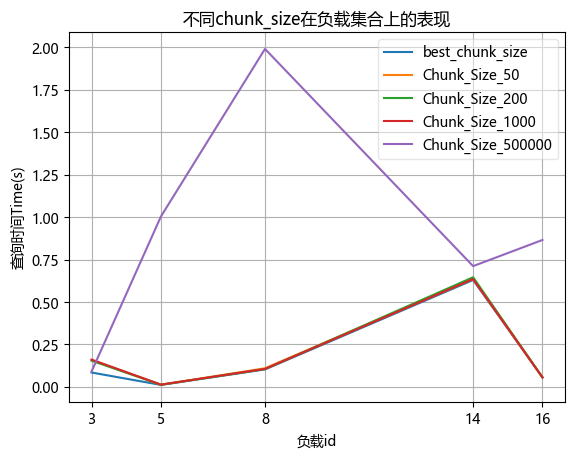

In [27]:
import os
import pandas as pd
import matplotlib.pyplot as plt

def read_csv(file_path, start, end):
    df = pd.read_csv(file_path, skiprows=range(1, start), nrows=end-start+1)
    # print(df)
    return df[["id", "Time"]]

def read_csv_ids(file_path, ids):
    df = pd.read_csv(file_path)
    return df.iloc[ids][["id", "Time"]]

def draw_all(best_chunk_size, chunk_size_50, chunk_size_200, chunk_size_1000, chunk_size_500000):
    plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
    plt.plot(best_chunk_size["id"], best_chunk_size["Time"], label="best_chunk_size")
    plt.plot(chunk_size_50["id"], chunk_size_50["Time"], label="Chunk_Size_50")
    plt.plot(chunk_size_200["id"], chunk_size_200["Time"], label="Chunk_Size_200")
    plt.plot(chunk_size_1000["id"], chunk_size_1000["Time"], label="Chunk_Size_1000")
    plt.plot(chunk_size_500000["id"], chunk_size_500000["Time"], label="Chunk_Size_500000")
    
    plt.xlabel("负载id")
    plt.ylabel("查询时间Time(s)")
    plt.title("不同chunk_size在负载集合上的表现")
    
    plt.grid(True)
    plt.xticks(best_chunk_size["id"])

    # plt.legend()
    plt.legend().get_frame().set_alpha(0.5)
    
    folder_path = f"./query_2"
    if not os.path.exists(folder_path):
            os.makedirs(folder_path)
    plt.savefig(f"./query_2/Final_Result.png")
    
    plt.show()

best_chunk_size = read_csv("query_2_result.csv", 1, 5)


ids = [3-1, 5-1, 8-1, 14-1, 16-1]

chunk_size_50 = read_csv_ids("result_segment_tree50.csv", ids)
chunk_size_200 = read_csv_ids("result_segment_tree200.csv", ids)
chunk_size_1000 = read_csv_ids("result_segment_tree1000.csv", ids)
chunk_size_500000 = read_csv_ids("result_segment_tree500000.csv", ids)

draw_all(best_chunk_size, chunk_size_50, chunk_size_200, chunk_size_1000, chunk_size_500000)

